# Introduction (WIP)

From the merger of the ABA and NBA to the new In-Season Tournament, the NBA has been through many different eras that each came with revolutionary changes to the game. One of the most important eras is that of today with the 3-Point Revolution who's inception can be traced to the implementation of the radical 3-Point line in 1976. Anyone who has followed the NBA closely over the course of the past decade can see with their eyes the boom of the 3-Point shot and how the product on the court is impacted greatly by it when in the decades before that was not the case.

In this study, NBA game and season data from the 1999–2000 to 2022–2023 regular seasons is analyzed to observe 3-Point shooting trends in the NBA and provide a scoring analysis that looks into shooting habits of players today.


**Questions to keep in mind**
1. When and how did the NBA 3-Point boom really arrive within the span of the past 20 years?
2. What are some common shotting habits that players today have opposed to their veteran counterparts from the early 2000s?


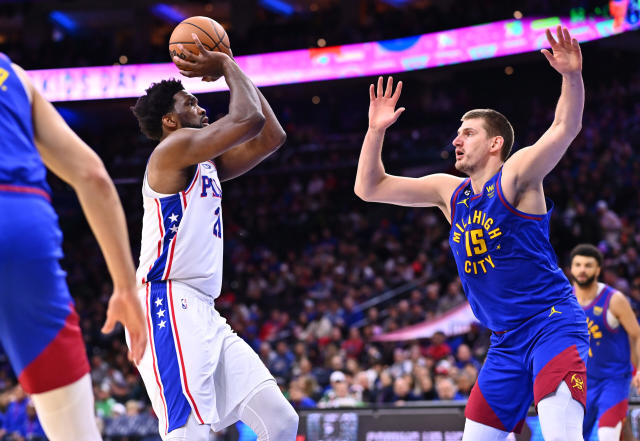

In [2]:
#Importing our packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.patches import Circle, Rectangle, Arc
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Data Overview

For this exploration of 3-Point shooting we'll be implementing the use of 3 different data sets. All DataFrames have been cleaned to have no missing or null values.

* **Team Statistics Dataset**:

>Mostly comprised of Field Goals made and attempt rates by teams over the course of many seasons.

In [3]:
#importing Team Stats DataFrame
team_totals = pd.read_csv('/kaggle/input/nba-datasets/Team Stats Per Game.csv')

#only including the seasons between 1999 and 2023
team_totals = team_totals.loc[(team_totals['season'] < 2024) & (team_totals['season'] > 1999)]

#show a preview of the DataFrame
team_totals.head()

,season,lg,team,abbreviation,playoffs,g,mp_per_game,fg_per_game,fga_per_game,fg_percent,...,ft_percent,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game
31,2023,NBA,Atlanta Hawks,ATL,False,82.0,242.1,44.6,92.4,0.483,...,0.818,11.2,33.2,44.4,25.0,7.1,4.9,12.9,18.8,118.4
32,2023,NBA,Boston Celtics,BOS,False,82.0,243.7,42.2,88.8,0.475,...,0.812,9.7,35.6,45.3,26.7,6.4,5.2,13.4,18.8,117.9
33,2023,NBA,Brooklyn Nets,BRK,False,82.0,240.6,41.5,85.1,0.487,...,0.800,8.2,32.3,40.5,25.5,7.1,6.2,13.7,21.1,113.4
34,2023,NBA,Chicago Bulls,CHI,False,82.0,242.7,42.5,86.8,0.490,...,0.809,8.5,33.9,42.4,24.5,7.9,4.5,13.4,18.9,113.1
35,2023,NBA,Charlotte Hornets,CHO,False,82.0,241.8,41.3,90.4,0.457,...,0.749,11.0,33.5,44.5,25.1,7.7,5.2,14.2,20.3,111.0


* **Indiviual Player Shooting Dataset**:

>Focuses on providing player shooting rates from diffeent distances on the NBA court.

In [4]:
#importing Player Shooting DataFrame
player_shooting = pd.read_csv('/kaggle/input/nba-datasets/Player Shooting.csv')


#dropping column that have no use in analysis and most values were NA
player_shooting.drop(['num_heaves_made', 'num_heaves_attempted', 'birth_year', 'num_of_dunks', 'percent_dunks_of_fga', 'percent_assisted_x2p_fg', 'percent_assisted_x3p_fg', 'percent_corner_3s_of_3pa', 'corner_3_point_percent'], 
                     axis=1, 
                     inplace=True)

#cleaning up postion column as there are players with double postion labels (ex: "PG-SG")
player_shooting['pos'] = player_shooting['pos'].str.replace('-SG', '')
player_shooting['pos'] = player_shooting['pos'].str.replace('-SF', '')
player_shooting['pos'] = player_shooting['pos'].str.replace('-C', '')
player_shooting['pos'] = player_shooting['pos'].str.replace('-PF', '')
player_shooting['pos'] = player_shooting['pos'].str.replace('-PG', '')
player_shooting['pos'] = player_shooting['pos'].str.replace('-PG-SF', '')

#renaming some columns for clarity
player_shooting.rename(columns = {'pos':'Position', 'lg':'league', 'tm':'team', 'g':'game within season', 'mp':'minutes played'}, 
                       inplace = True)

#only including the seasons between 1999 and 2023
player_shooting = player_shooting.loc[(player_shooting['season'] < 2024) & (player_shooting['season'] > 1999)]

#dropping NA values
player_shooting = player_shooting.dropna()

#previewing the DataFrame    
player_shooting.head()

,seas_id,season,player_id,player,Position,age,experience,league,team,game within season,...,percent_fga_from_x3_10_range,percent_fga_from_x10_16_range,percent_fga_from_x16_3p_range,percent_fga_from_x3p_range,fg_percent_from_x2p_range,fg_percent_from_x0_3_range,fg_percent_from_x3_10_range,fg_percent_from_x10_16_range,fg_percent_from_x16_3p_range,fg_percent_from_x3p_range
415,30458,2023,5025,A.J. Green,SG,23,1,NBA,MIL,35,...,0.016,0.032,0.072,0.840,0.450,0.400,0.500,0.500,0.444,0.419
419,30467,2023,5027,AJ Griffin,SF,19,1,NBA,ATL,72,...,0.165,0.173,0.075,0.486,0.536,0.630,0.568,0.522,0.375,0.390
420,30462,2023,4219,Aaron Gordon,PF,27,9,NBA,DEN,68,...,0.183,0.064,0.037,0.227,0.628,0.782,0.388,0.286,0.357,0.347
421,30463,2023,4582,Aaron Holiday,PG,26,5,NBA,ATL,63,...,0.168,0.132,0.077,0.400,0.424,0.612,0.216,0.310,0.529,0.409
422,30464,2023,4805,Aaron Nesmith,SF,23,3,NBA,IND,73,...,0.136,0.063,0.020,0.532,0.496,0.639,0.263,0.486,0.333,0.366


* **Positional Shooting DataFrame**:

>These collection of datasets provide positional data of everyshot attempted by every player in the NBA within the specified season.

In [5]:
#Import out shot location datasets for the years we will be using
shots_04 = pd.read_csv("/kaggle/input/nba-datasets/NBA_2004_Shots.csv")
shots_07 = pd.read_csv("/kaggle/input/nba-datasets/NBA_2007_Shots.csv")
shots_11 = pd.read_csv("/kaggle/input/nba-datasets/NBA_2011_Shots.csv")
shots_15 = pd.read_csv("/kaggle/input/nba-datasets/NBA_2015_Shots.csv")
shots_19 = pd.read_csv("/kaggle/input/nba-datasets/NBA_2019_Shots.csv")
shots_23 = pd.read_csv("/kaggle/input/nba-datasets/NBA_2023_Shots.csv")

#Changing decimal place in X and Y coordinates to fit shot chart we'll be using
shots_04[['LOC_X', 'LOC_Y']] = (shots_04[['LOC_X', 'LOC_Y']]*10)
shots_07[['LOC_X', 'LOC_Y']] = (shots_07[['LOC_X', 'LOC_Y']]*10)
shots_11[['LOC_X', 'LOC_Y']] = (shots_11[['LOC_X', 'LOC_Y']]*10)
shots_15[['LOC_X', 'LOC_Y']] = (shots_15[['LOC_X', 'LOC_Y']]*10)
shots_19[['LOC_X', 'LOC_Y']] = (shots_19[['LOC_X', 'LOC_Y']]*10)
shots_23[['LOC_X', 'LOC_Y']] = (shots_23[['LOC_X', 'LOC_Y']]*10)

#All DataFrames have the same form, previewing just one
shots_04.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,Above the Break 3,Left Side Center,LC,24+ ft.,200.0,213.5,25,6,0,0
1,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,52.5,0,6,0,2
2,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,Mid-Range,Left Side Center,LC,16-24 ft.,133.0,244.5,23,6,0,9
3,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Mid-Range,Left Side,L,16-24 ft.,164.0,139.5,18,6,0,31
4,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Mid-Range,Right Side,R,16-24 ft.,-158.0,78.5,16,6,0,55


# **Shooting Breakdown**

**2s vs 3s**

Now lets get started and take a look at NBA players 3-Point shooting rates over the past 20 years

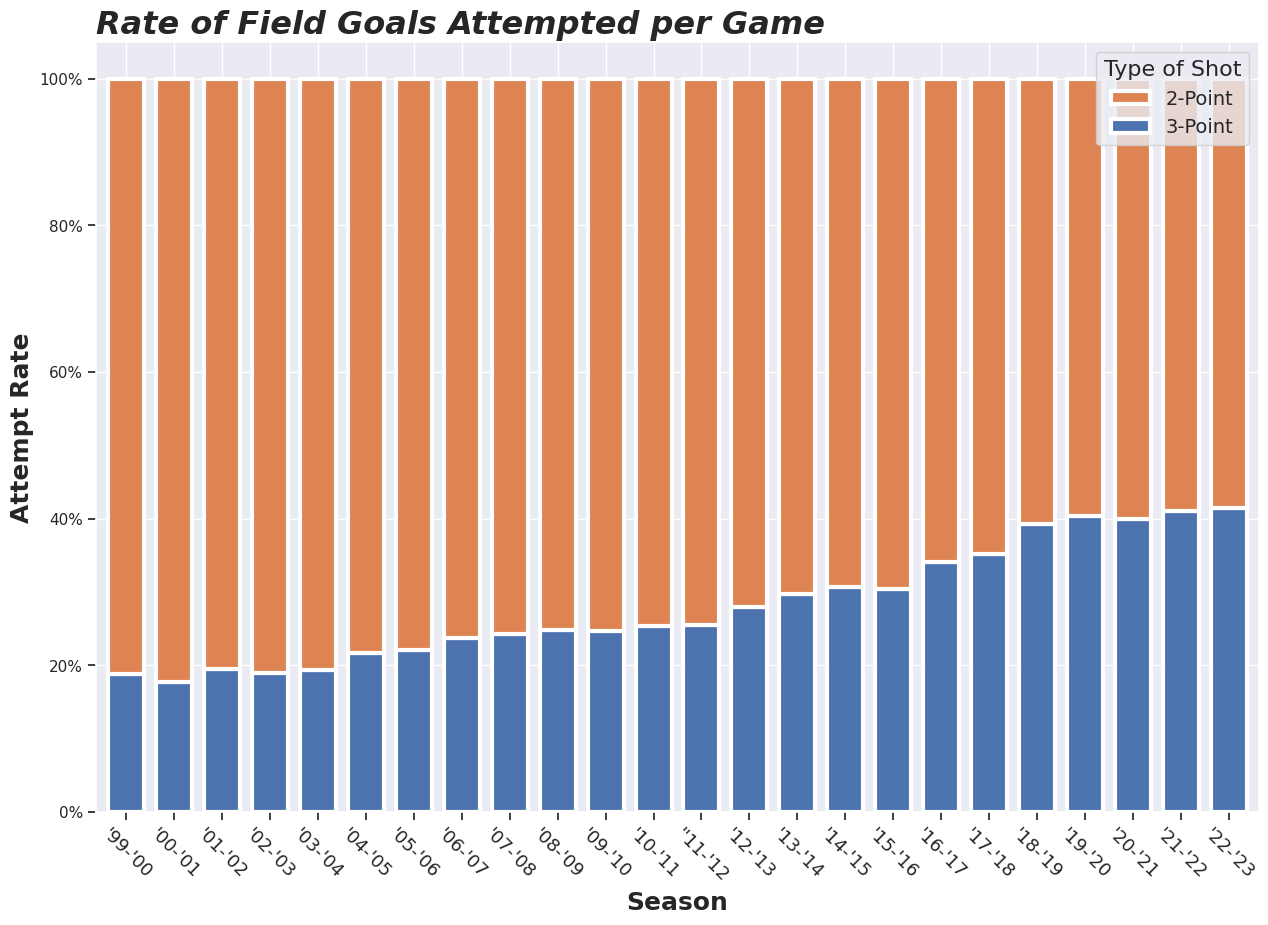

In [6]:
sns.set(rc={"figure.figsize":(15, 10)})
sns.color_palette("tab10")


attempted = player_shooting.groupby('season')\
            [['percent_fga_from_x3p_range', 'percent_fga_from_x2p_range']]\
            .mean()\
            .reset_index()


#plotting
ax = attempted.set_index('season').plot(kind='bar', 
                                   stacked=True,
                                   width = 0.75,
                                   edgecolor = "white", 
                                   linewidth=3)


#formating the ylabels to be percentages instead of decimals
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#formating the xlabels
ax.set_xticks(range(len(attempted.set_index('season'))))
ax.set_xticklabels(["'99-'00", "'00-'01", "'01-'02", "'02-'03", "'03-'04", "'04-'05", "'05-'06", "'06-'07", "'07-'08", "'08-'09", "'09-'10", "'10-'11", "''11-'12", "'12-'13", "'13-'14", "'14-'15", "'15-'16", "'16-'17", "'17-'18", "'18-'19", "'19-'20", "'20-'21","'21-'22", "'22-'23"], 
                   rotation=-45, 
                   size=13)

#ax.set_yticklabels(size=13)
ax.tick_params(bottom=True, 
               left=True)


ax.axes.set_title('Rate of Field Goals Attempted per Game', 
                  fontsize=23, 
                  loc='left', 
                  fontweight='bold', 
                  fontstyle='oblique')
ax.set_xlabel("Season", 
              fontsize=18, 
              fontweight='bold')
ax.set_ylabel("Attempt Rate", 
              fontsize=18, 
              fontweight='bold')

#LEGEND
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), 
          reversed(["3-Point", "2-Point"]), 
          title='Type of Shot', 
          loc='upper right',
          title_fontsize= 16,
          fontsize = 14)

Over the course of the past 20 years we see a gradual growth of 3s being attempted per game by players. From 1 out of every 5 shots attempted being a 3-pointer in the *1999-2000* season to almost 2 in every 5 shots in the present NBA being a 3. 

To some this might not be an astronomical jump in shotting rates but it's staggering to see such a jump especially for on lookers of the sport who felt the shockwaves of such a change in player output with such things as points per game and Field Goal percentages.

**Are Players Actually Making These 3s?**

Focusing on Field Goal (FG) percentage did this three-point boom have an effect of how well players where shotting the 3 ball?

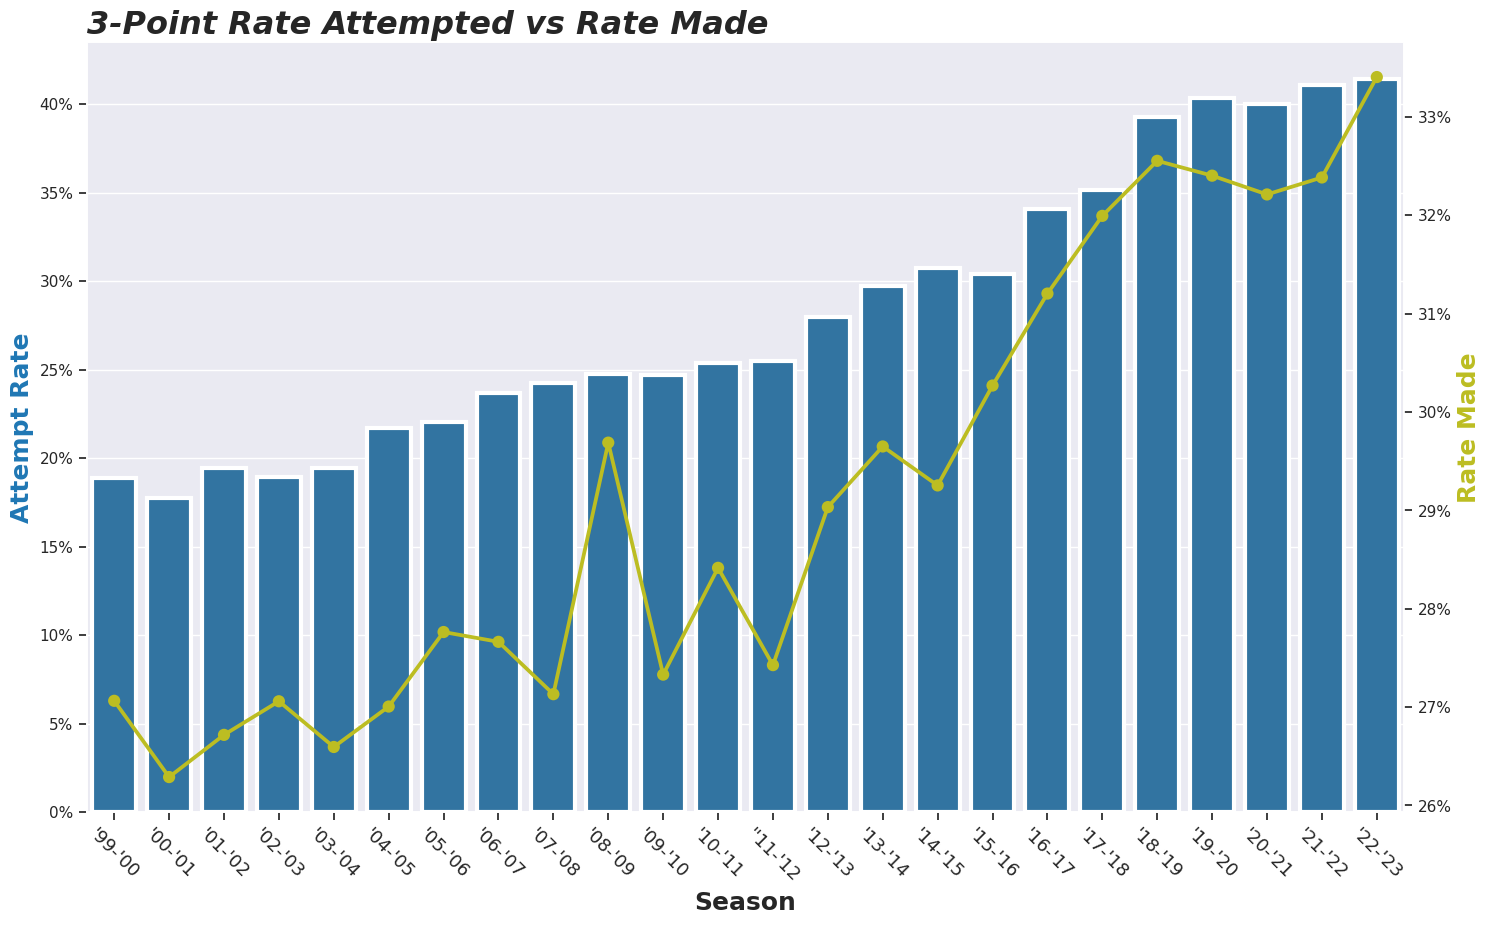

In [7]:
#costumizing plot
fig, ax = plt.subplots(figsize=(17, 10))
sns.set_theme(style="dark", palette='binary')

#plotting
g = sns.barplot(data=player_shooting, 
                x='season', 
                y='percent_fga_from_x3p_range', 
                linewidth=3, 
                errorbar=None, 
                ax=ax, 
                color='tab:blue',
                edgecolor = "white")

ax2 = ax.twinx()
g = sns.pointplot(data=player_shooting, 
                  x='season', 
                  y='fg_percent_from_x3p_range',  
                  errorbar=None, 
                  ax=ax2, 
                 color='tab:olive')


#Title and axes labels
ax.axes.set_title('3-Point Rate Attempted vs Rate Made', 
                  fontsize=23, 
                  loc='left', 
                  fontweight='bold', 
                  fontstyle='oblique')
ax.set_xlabel("Season", 
              fontsize=18, 
              fontweight='bold')
ax.set_ylabel("Attempt Rate", 
              fontsize=18, 
              fontweight='bold', 
              color='tab:blue')
ax2.set_ylabel("Rate Made", 
               fontsize=18, 
               fontweight='bold', 
               color='tab:olive')


#formating the ylabels to be percentages instead of decimals
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

ax.set_xticks(range(24))
ax.set_xticklabels(["'99-'00", "'00-'01", "'01-'02", "'02-'03", "'03-'04", "'04-'05", "'05-'06", "'06-'07", "'07-'08", "'08-'09", "'09-'10", "'10-'11", "''11-'12", "'12-'13", "'13-'14", "'14-'15", "'15-'16", "'16-'17", "'17-'18", "'18-'19", "'19-'20", "'20-'21","'21-'22", "'22-'23"], 
                  rotation=-45, size=13)
ax.tick_params(bottom=True, left=True)

Visually we see something interesting happen with FG percentage as we do with FGA rates as both trend upwards as we approach the present. Even while shooting a higher percentage of 3s NBA players maintained and keeped up by making said 3s at a high level. 

Looking closely we can also observe a inflection point in the *2014-2015* season, with since then the rate of 3-Pointers made made continously going upwards with a slight dip that goes back up in the 2022-2023 season and excides previous 3-Point made rates in the last 20 years.

**3-Point Shot by Position**

Now that we see this from top down point of view looking at all players, what kind of effect did the three-point shot have on each of the five positions in the NBA; each obviously having their own strengths and weakness when shotting the basketball. 

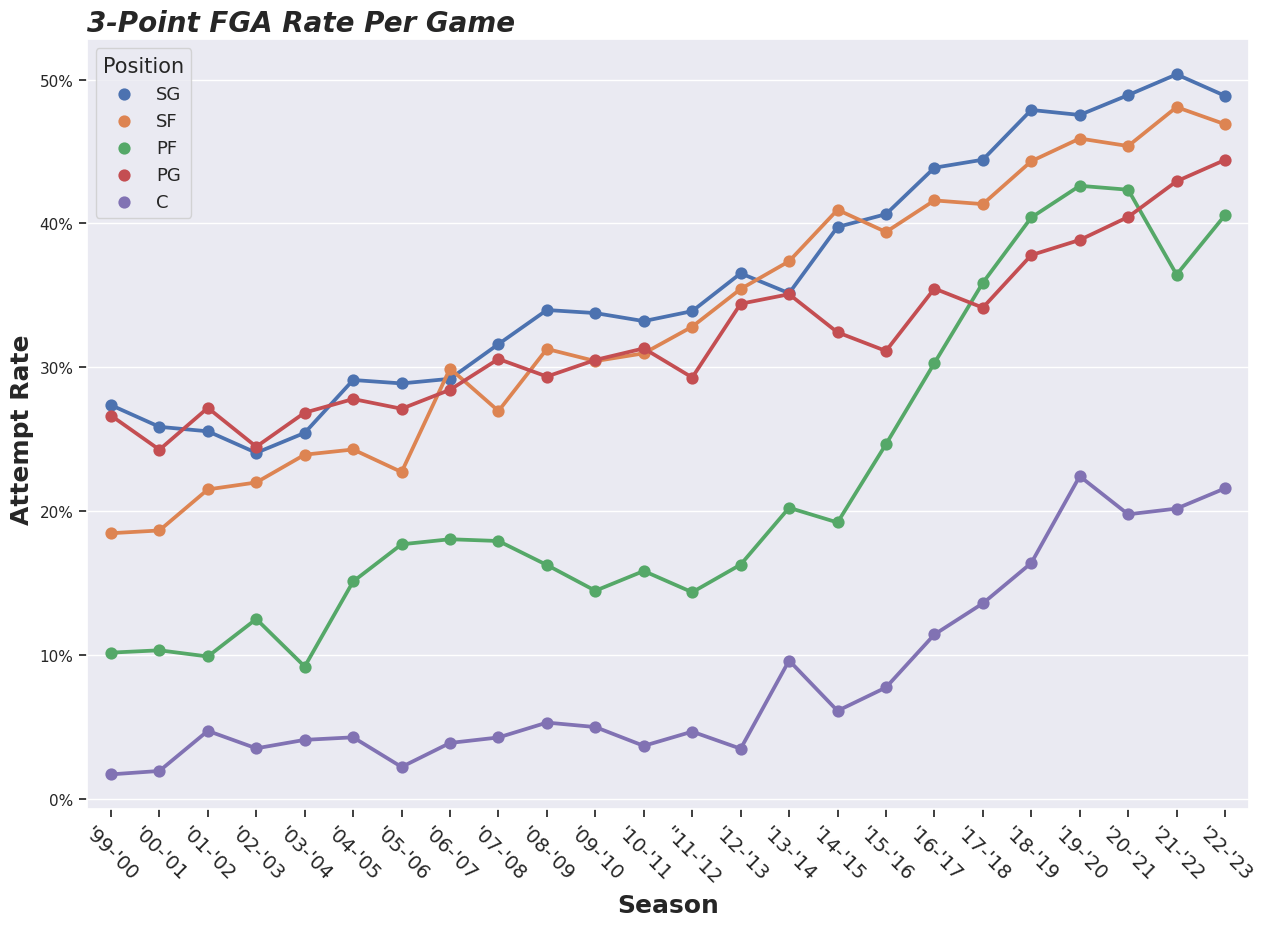

In [8]:
#costumizing plot
sns.set(rc={"figure.figsize":(15, 10)})
sns.set_style("darkgrid")
sns.color_palette("tab10")

#plotting
ax = sns.pointplot(data=player_shooting, 
                   x='season', 
                   y='percent_fga_from_x3p_range',
                   errorbar=None, 
                   hue='Position')


#Labels
ax.axes.set_title('3-Point FGA Rate Per Game', 
                  fontsize=20, 
                  loc='left', 
                  fontweight='bold', 
                  fontstyle='oblique')
ax.set_xlabel("Season", 
              fontsize=18, 
              fontweight='bold')
ax.set_ylabel("Attempt Rate ", 
              fontsize=18, 
              fontweight='bold')


#formating the ylabels to be percentages instead of decimals
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#ticks
ax.set_xticks(range(24))
ax.set_xticklabels(["'99-'00", "'00-'01", "'01-'02", "'02-'03", "'03-'04", "'04-'05", "'05-'06", "'06-'07", "'07-'08", "'08-'09", "'09-'10", "'10-'11", "''11-'12", "'12-'13", "'13-'14", "'14-'15", "'15-'16", "'16-'17", "'17-'18", "'18-'19", "'19-'20", "'20-'21","'21-'22", "'22-'23"], 
                   rotation=-45, 
                   size=14)
ax.tick_params(bottom=True, 
               left=True)


ax.legend(title='Position', 
          loc='upper left', 
          title_fontsize= 15, 
          fontsize = 13)

Initially at the start of the milenia we see the 3 positions with most long range shooting proficiency **(see next graph)** Point Guards (PG), Shooting Guards (SG), and Small Forwards (SF) maintain high rates of 3-Point attempts ranging from about 20% to 30% per game. The two remaining positions, Centers (C) and Power Forwards (PF), start the millenia shooting a incrediably low rate of 3s with PFs shooting them at a rate of about 10% per game and Cs closer to 2%. 

As time progresses we see not only a spike in attempts for PGs, SGs, SFs as one would expect with players with the skill set to do so but also from PFs and Cs who historically are opposites from a shooting skills standpoint. PFs would go on to shot 3s at a rate of past 40% per game in some seasons while Cs who would barely attempt a 3-Pointers in the early 2000s now shot them at a rate just above 20% per game.

For folks who watch NBA basketball regularly this change can be seen on the court with the last two winners of the NBA MVP award being 2 Centers (Joel Embiid and Nikola Jokic) who shot an extensive amount of 3s in each of their MVP winning seasons and even before.

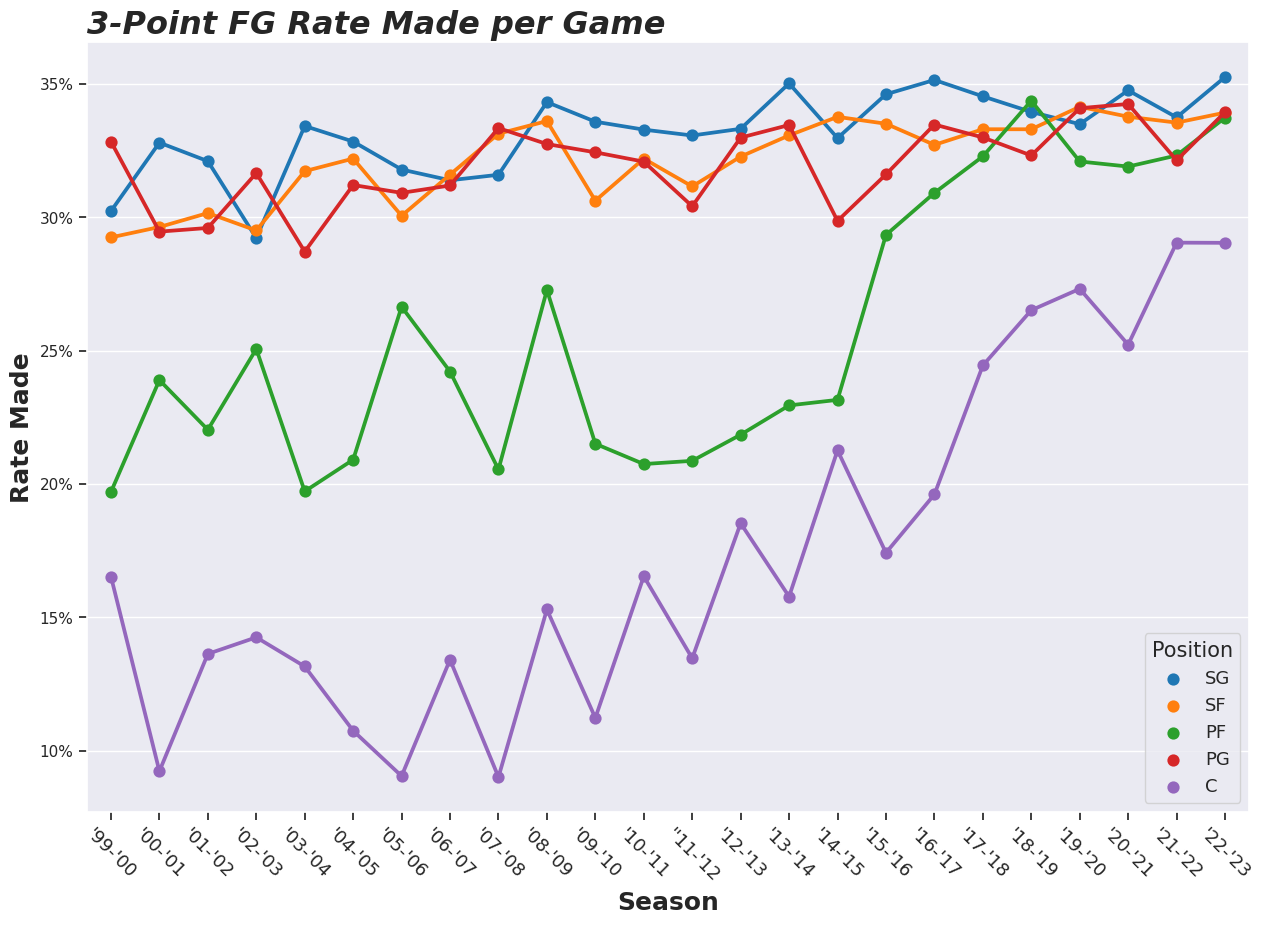

In [9]:
#costumizing plot
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_theme(style="darkgrid", palette="tab10")

#plotting
g = sns.pointplot(data=player_shooting, 
                  x='season', 
                  y='fg_percent_from_x3p_range', 
                  errorbar=None, 
                  hue='Position', 
                  ax=ax)
#ax2 = ax.twinx()
#g = sns.barplot(data=nba_shooting, x='season', y='percent_fga_from_x3p_range', hue='Position', linewidth=1, ci=None, ax=ax2)

ax.axes.set_title('3-Point FG Rate Made per Game', 
                  fontsize=23, 
                  loc='left', 
                  fontweight='bold', 
                  fontstyle='oblique')
ax.set_xlabel("Season", 
              fontsize=18, 
              fontweight='bold')
ax.set_ylabel("Rate Made", 
              fontsize=18, 
              fontweight='bold')


#formating the ylabels to be percentages instead of decimals
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
#ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

ax.set_xticks(range(24))
ax.set_xticklabels(["'99-'00", "'00-'01", "'01-'02", "'02-'03", "'03-'04", "'04-'05", "'05-'06", "'06-'07", "'07-'08", "'08-'09", "'09-'10", "'10-'11", "''11-'12", "'12-'13", "'13-'14", "'14-'15", "'15-'16", "'16-'17", "'17-'18", "'18-'19", "'19-'20", "'20-'21","'21-'22", "'22-'23"], 
                   rotation=-45, 
                   size=13)
ax.tick_params(bottom=True, 
               left=True)

#Legend
ax.legend(title='Position', 
          loc='lower right',
          title_fontsize= 15,
          fontsize = 13)

Looking at the rate in which player were actually making 3s it's not surprising to see PGs, SGs, and SFs ahooting at such a high rate but what's more suprsing is PFs and Cs catching up with their shorter and quicker counterparts in the 3-Point making department.

**Is there actually any team success coming from shooting more 3s?**

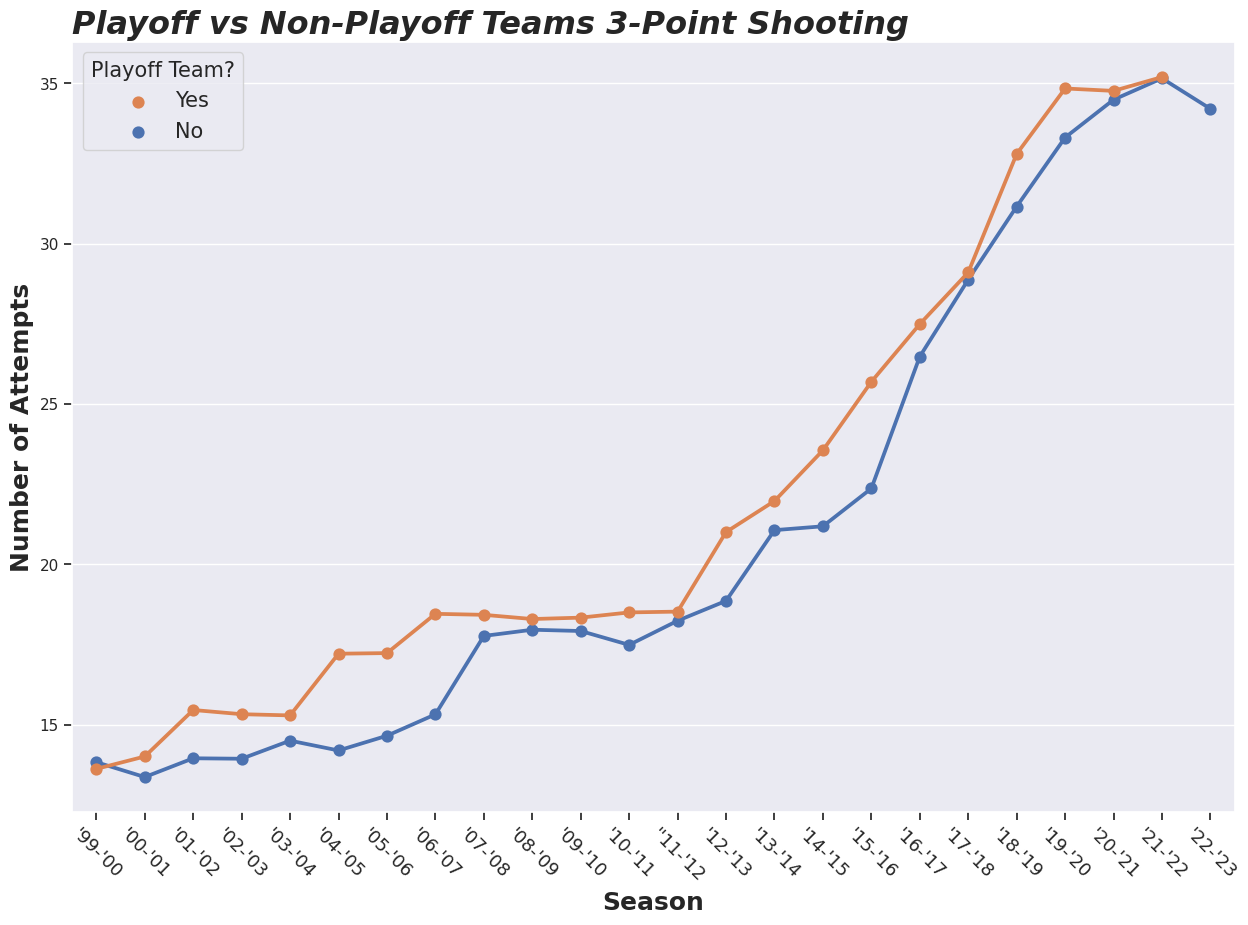

In [10]:
#costumizing plot
sns.set_theme(style="darkgrid")
sns.set(rc={"figure.figsize":(15, 10)})

#plotting
ax = sns.pointplot(data=team_totals, 
                   x='season', 
                   y='x3pa_per_game', 
                   hue='playoffs', 
                   errorbar=None)

ax.set_xticks(range(24))
ax.set_xticklabels(["'99-'00", "'00-'01", "'01-'02", "'02-'03", "'03-'04", "'04-'05", "'05-'06", "'06-'07", "'07-'08", "'08-'09", "'09-'10", "'10-'11", "''11-'12", "'12-'13", "'13-'14", "'14-'15", "'15-'16", "'16-'17", "'17-'18", "'18-'19", "'19-'20", "'20-'21","'21-'22", "'22-'23"], 
                  rotation=-45, size=13)
ax.tick_params(bottom=True, 
               left=True)

#Labels
ax.axes.set_title('Playoff vs Non-Playoff Teams 3-Point Shooting', 
                  fontsize=23, 
                  loc='left', 
                  fontweight='bold', 
                  fontstyle='oblique')
ax.set_xlabel("Season", 
              fontsize=18, 
              fontweight='bold')
ax.set_ylabel("Number of Attempts", 
              fontsize=18, 
              fontweight='bold')

#Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), 
          reversed(["No", "Yes"]), 
          title='Playoff Team?', 
          loc='upper left',
          title_fontsize= 15, 
          fontsize = 15)

Using “Playoff appearances” by a team as our metric of success (making the playoffs signifies your are one of the top 8 teams in your respective Conference) we see playoffs making teams continually attempted more 3s than their non playoff making counterparts since the beginning of the millennia.

# **Shot Mapping**

To get a better understanding of what was happening on the court itself one can examine shot location data which gives us the ability to map onto a plane all shots attempted during an entire season.

> **Note:** Due to a majority of basketball shots happening directly under or next to the rim, a maximum cutoff for shots was established when visualizing the entire court so hexbins around the rim would not drown out other hexbins. The maximum cut off chossen was 400 shots.

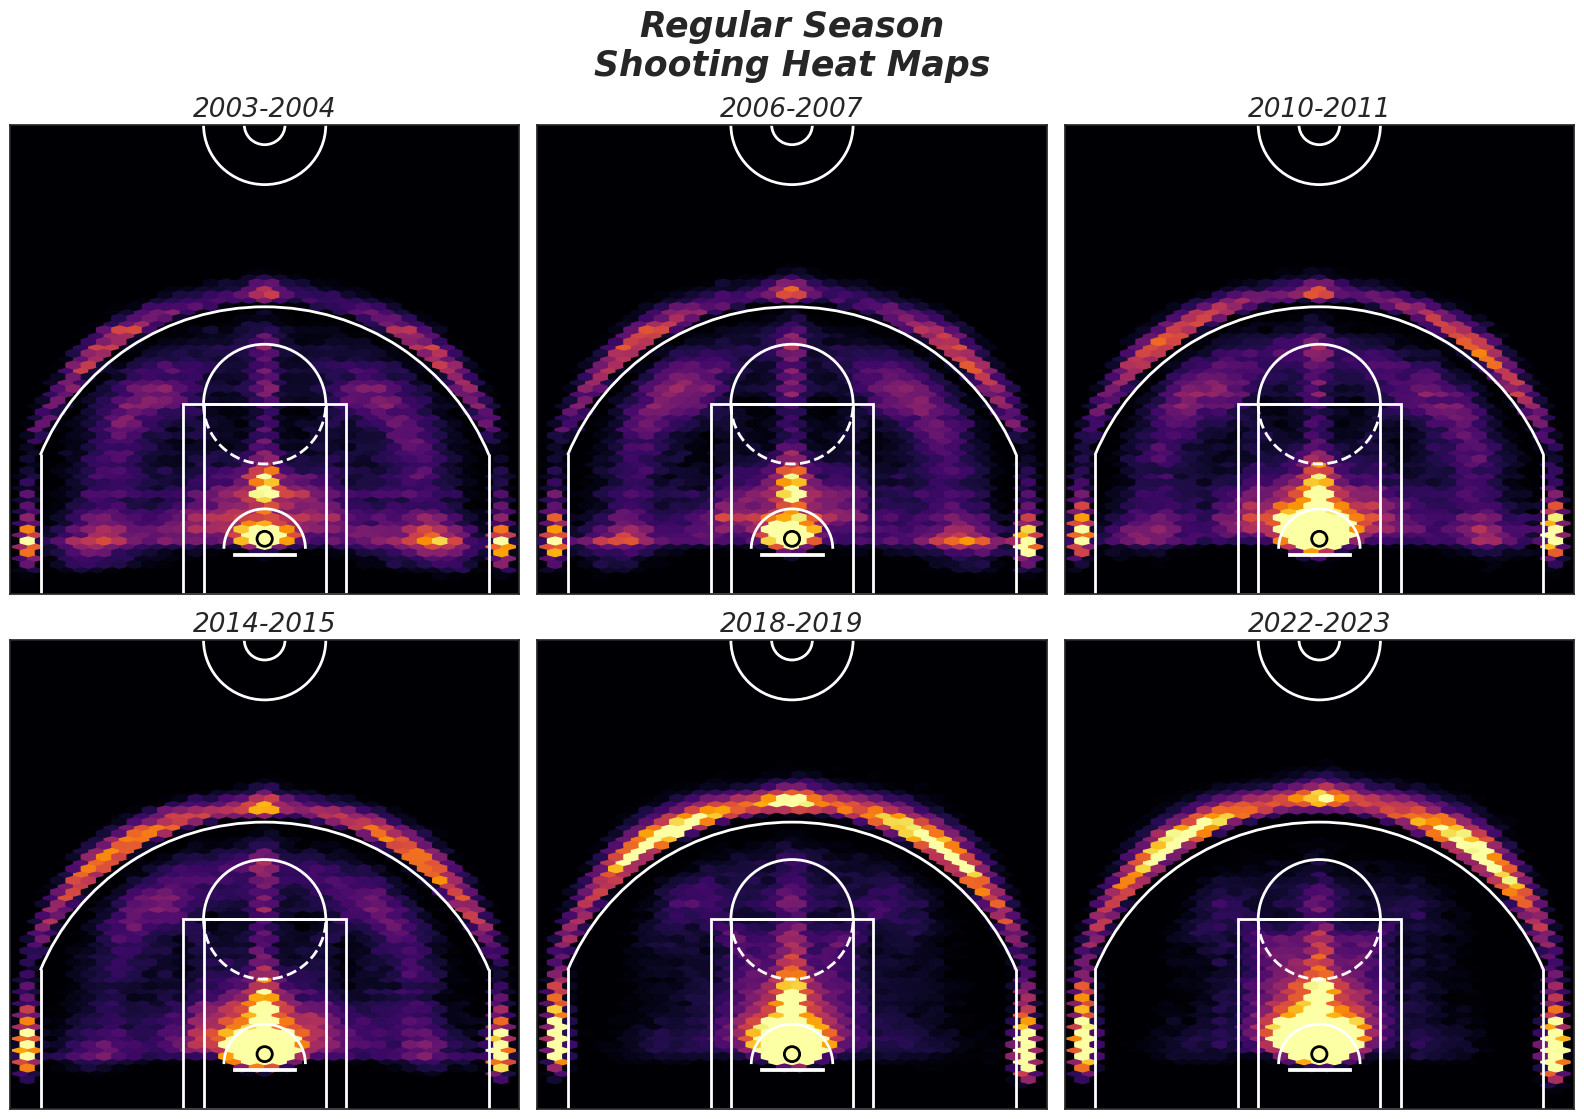

In [21]:
###############################################
#THE TEMPLATE OF THIS CODE WAS TAKEN FROM . I HAVE ALTERED PARTS OF THE CODE TO WORK WITH THE COORDINATE VALUES IN MY DATASET
#Drawing basketball court
def draw_court(ax=None, color='white', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()
        
    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    hoop = Circle((0, 55), radius=7.5, linewidth=lw, color="black", fill=False)

    # Create backboard
    backboard = Rectangle((-30, 40), 60, -1, linewidth=lw, color=color)

    # The paint
    outer_box = Rectangle((-80, 0), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, 0), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 190), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 190), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 45), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color="white")

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, 0), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, 0), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 50), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    #Center Court
    center_outer_arc = Arc((0, 470), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 470), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, 470), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax
################################################


#Setting up plot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,11.4),  sharex=True, sharey=True)
plt.xlim(-250, 250)
plt.ylim(0, 470)


#Ploting each court
#we use larger values than the axis limits to ensure that hexagons go all the way to the boundaries of our draw court 
#(hexagons outside the plot area are clipped so we won’t see them)
ax1= ax[0,0].hexbin(shots_04['LOC_X'], 
           shots_04['LOC_Y'], 
           gridsize=(40, 40), 
           extent=(-300, 300, 0, 470), 
           cmap='inferno', 
           vmin=20, 
           vmax=450)

ax2 = ax[0,1].hexbin(shots_07['LOC_X'], 
           shots_07['LOC_Y'], 
           gridsize=(40, 40), 
           extent=(-300, 300, 0, 470), 
           cmap='inferno', 
           vmin=20, 
           vmax=450)

ax3 = ax[0,2].hexbin(shots_11['LOC_X'], 
           shots_11['LOC_Y'], 
           gridsize=(40, 40), 
           extent=(-300, 300, 0, 470), 
           cmap='inferno', 
           vmin=20, 
           vmax=450)

ax4 = ax[1,0].hexbin(shots_15['LOC_X'], 
           shots_15['LOC_Y'], 
           gridsize=(40, 40), 
           extent=(-300, 300, 0, 470), 
           cmap='inferno', 
           vmin=20, 
           vmax=450)

ax5 = ax[1,1].hexbin(shots_19['LOC_X'], 
           shots_19['LOC_Y'], 
           gridsize=(40, 40), 
           extent=(-300, 300, 0, 470), 
           cmap='inferno', 
           vmin=20, 
           vmax=450)


ax6 = ax[1,2].hexbin(shots_23["LOC_X"], 
           shots_23["LOC_Y"], 
           gridsize=(40, 40), 
           extent=(-300, 300, 0, 470), 
           cmap="inferno", 
           vmin=20, 
           vmax=450)

#Add labels to each court image
ax[0, 0].set_title('2003-2004', fontsize=19, fontweight='medium', fontstyle='oblique')
ax[0, 1].set_title('2006-2007', fontsize=19, fontweight='medium', fontstyle='oblique')
ax[0, 2].set_title('2010-2011', fontsize=19, fontweight='medium', fontstyle='oblique')
ax[1, 0].set_title('2014-2015', fontsize=19, fontweight='medium', fontstyle='oblique')
ax[1, 1].set_title('2018-2019', fontsize=19, fontweight='medium', fontstyle='oblique')
ax[1, 2].set_title('2022-2023', fontsize=19, fontweight='medium', fontstyle='oblique')

#Costimizing axis ticks and adding courts
for row in range(2):
    for col in range(3):
        ax[row, col].get_xaxis().set_visible(False)
        ax[row, col].get_yaxis().set_visible(False)
        draw_court(ax[row,col])
        
        
fig.suptitle("Regular Season\nShooting Heat Maps", fontsize=25, fontweight='bold', fontstyle='oblique')
fig.tight_layout()


plt.show()

From shot charts of the *2003-2004* season to that of *2022-2023* season we see a gradual movement away from the mid-range shot (long 2-Pointer) to an increase in 3-Pointers as the years went on. Along side the increase in 3s there was also an increase in shots concentrating around the ring pointing to a polarity in shot selection for players; either I shot a 3-Pointer or I take a more efficent and easier shot around the rim.

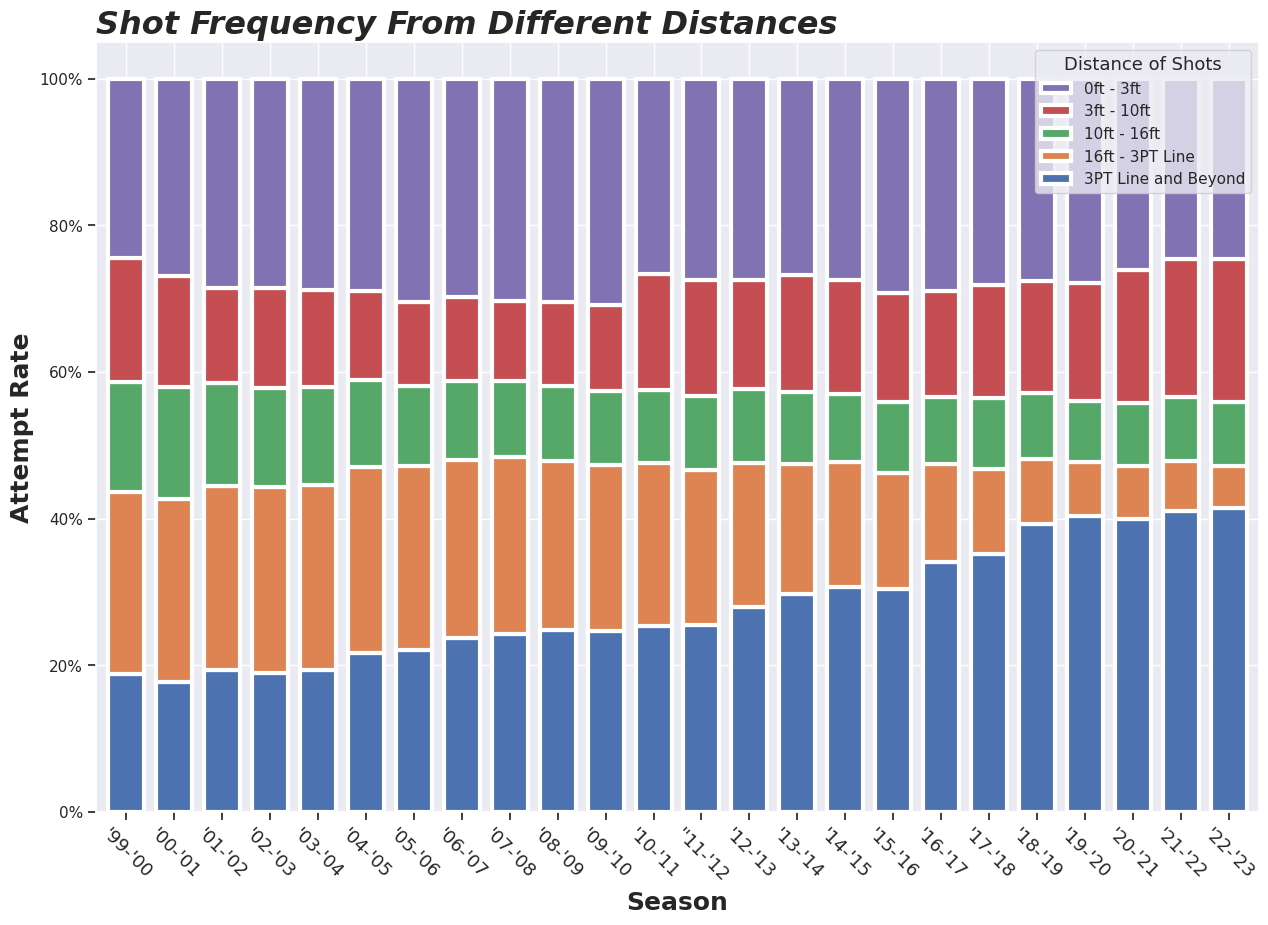

In [12]:
sns.set(rc={"figure.figsize":(15, 10)})
sns.color_palette("tab10")
sns.set(font_scale=1)

attempted = player_shooting.groupby('season')\
            [['percent_fga_from_x3p_range', 'percent_fga_from_x16_3p_range','percent_fga_from_x10_16_range',  'percent_fga_from_x3_10_range', 'percent_fga_from_x0_3_range']]\
            .mean()\
            .reset_index()

#plotting
ax = attempted.set_index('season').plot(kind='bar', 
                                   stacked=True,  
                                   width = 0.75, 
                                   edgecolor = "white", 
                                   linewidth=3)

#Y-AXIS
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#X-AXIS
ax.set_xticks(range(len(attempted.set_index('season'))))
ax.set_xticklabels(["'99-'00", "'00-'01", "'01-'02", "'02-'03", "'03-'04", "'04-'05", "'05-'06", "'06-'07", "'07-'08", "'08-'09", "'09-'10", "'10-'11", "''11-'12", "'12-'13", "'13-'14", "'14-'15", "'15-'16", "'16-'17", "'17-'18", "'18-'19", "'19-'20", "'20-'21","'21-'22", "'22-'23"], 
                   rotation=-45, 
                   size=13)
ax.tick_params(bottom=True, 
               left=True)

#LABELS
ax.axes.set_title('Shot Frequency From Different Distances', 
                  fontsize=23, 
                  loc='left', 
                  fontweight='bold', 
                  fontstyle='oblique')
ax.set_xlabel("Season", 
              fontsize=18, 
              fontweight='bold')
ax.set_ylabel("Attempt Rate", 
              fontsize=18, 
              fontweight='bold')


#LEGEND
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), 
          reversed(["3PT Line and Beyond", "16ft - 3PT Line", "10ft - 16ft", "3ft - 10ft", "0ft - 3ft"]), 
          title='Distance of Shots', 
          loc='upper right',
          title_fontsize= 13,
          fontsize = 11)

Looking further into the percentage of shots attempted from certain distances on the court one can see most shot rates from certain distances staying around a similar percentage range while one in particular almost being gone completely. The 16ft to 3-Point line shot (24ft) is almost going extinct with the boom of the 3-Point shot eating away at shots that would be taken at that distance historically.

# Scoring Analysis

Here now we'll take a more granular look at how shooting habits have changed over time (using machine leariong algo). It would be hard to find two players one from today and one from the early 2000s who both fit the same physical molds and playstyles to compare 3-Point shooting with ;**however** someone by the name of LeBron James exists.

Lebron provides us with a very unique look into a player that still plays at a relatively same pace and efficency today as he did in the early 2000s when he started his NBA career. Still averaging 25+ points per game in his 21st season he's found ways to evolve his playstyle with the times making him a prefect canidate for our study.

Lets look at some of the differences in Lebron's shooting patterns and habits from 2003 (his rookie season!) and 2023

In [13]:
#Building a dataset only of Lebron's stats
shots_04.drop(['SEASON_1', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'GAME_ID','HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 'ACTION_TYPE','SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB'], axis=1, inplace=True)
lebron_04 = shots_04.query('PLAYER_NAME == "LeBron James" & ZONE_RANGE != "Back Court Shot"')

lebron_04.head()

,SEASON_2,PLAYER_NAME,SHOT_MADE,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
258,2003-04,LeBron James,True,Less Than 8 ft.,-0.0,52.5,0,4,0,30
307,2003-04,LeBron James,False,Less Than 8 ft.,-0.0,52.5,0,4,1,20
431,2003-04,LeBron James,False,24+ ft.,210.0,203.5,25,4,5,5
570,2003-04,LeBron James,True,Less Than 8 ft.,-0.0,52.5,0,4,8,56
632,2003-04,LeBron James,True,Less Than 8 ft.,-0.0,52.5,0,4,10,55


<Figure size 1500x940 with 0 Axes>

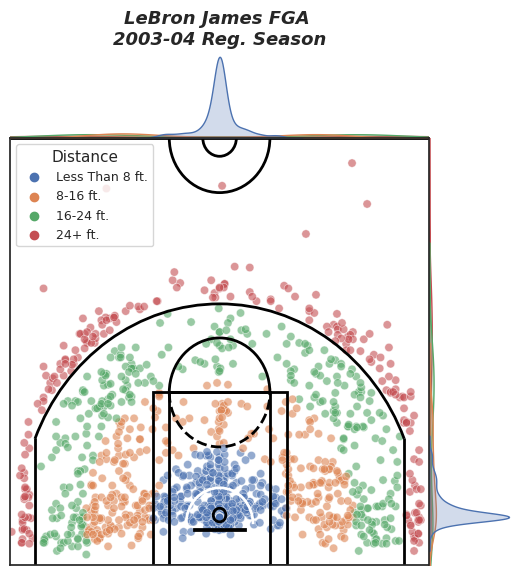

In [14]:
#setting up seaborn plot
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(15,9.4))

#Plotting
ax = sns.jointplot(data = lebron_04, 
                   x='LOC_X', 
                   y='LOC_Y', 
                   kind='scatter', 
                   hue='ZONE_RANGE', 
                   hue_order=['Less Than 8 ft.', '8-16 ft.', '16-24 ft.', '24+ ft.'], 
                   space=0, 
                   alpha=0.6)


#Court and axes
draw_court(outer_lines=True, color="black")
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.xlim(-250, 250)
plt.ylim(0, 470)

#Title
plt.title('LeBron James FGA \n2003-04 Reg. Season', 
          fontsize=13,
          loc='center',
          fontweight='bold',
          y=1.2, 
          fontstyle='oblique')

#Legend
plt.legend(title='Distance',
          loc='upper left',
          title_fontsize= 11,
          fontsize = 9)

plt.show()

<Figure size 1700x940 with 0 Axes>

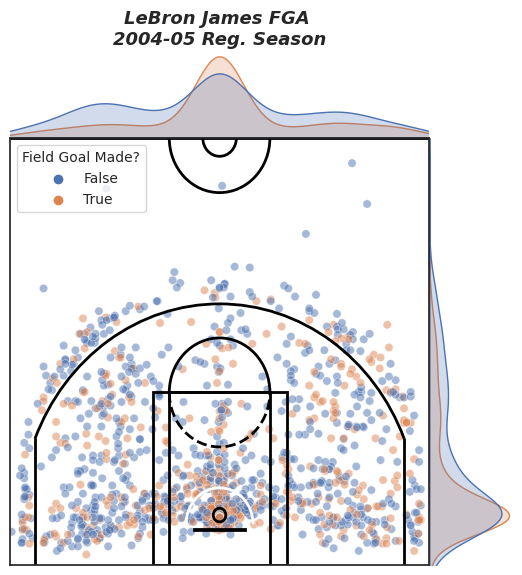

In [24]:
#setting up seaborn plot
sns.set_style("white")
plt.figure(figsize=(17,9.4))

#Plotting
ax = sns.jointplot(data = lebron_04, 
                   x='LOC_X', 
                   y='LOC_Y', 
                   kind='scatter',
                   hue='SHOT_MADE',
                   space=0, 
                   alpha=0.5)

#Court and axes
draw_court(outer_lines=True, color="black")
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.xlim(-250, 250)
plt.ylim(0, 470)

#Title
plt.title('LeBron James FGA \n2004-05 Reg. Season', 
          fontsize=13,
          loc='center',
          fontweight='bold',
          y=1.2, 
          fontstyle='oblique')

#Legend
plt.legend(title='Field Goal Made?', 
           loc='upper left', 
           title_fontsize= 10, 
           fontsize = 10)
           

plt.show()

In [15]:
#Building a dataset only of Lebron's stats
shots_23.drop(['SEASON_1', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'GAME_ID','HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 'ACTION_TYPE','SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB'], axis=1, inplace=True)
lebron_23 = shots_23.query('PLAYER_NAME == "LeBron James" & ZONE_RANGE != "Back Court Shot"')

lebron_23.head()

,SEASON_2,PLAYER_NAME,SHOT_MADE,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
116361,2022-23,LeBron James,False,24+ ft.,37.0,310.5,26,1,9,26
116363,2022-23,LeBron James,False,16-24 ft.,-18.0,212.5,16,1,8,38
116364,2022-23,LeBron James,False,8-16 ft.,70.0,143.5,11,1,8,10
116368,2022-23,LeBron James,True,Less Than 8 ft.,26.0,68.5,3,1,5,24
116378,2022-23,LeBron James,False,24+ ft.,-229.0,65.5,22,1,1,2


<Figure size 1500x940 with 0 Axes>

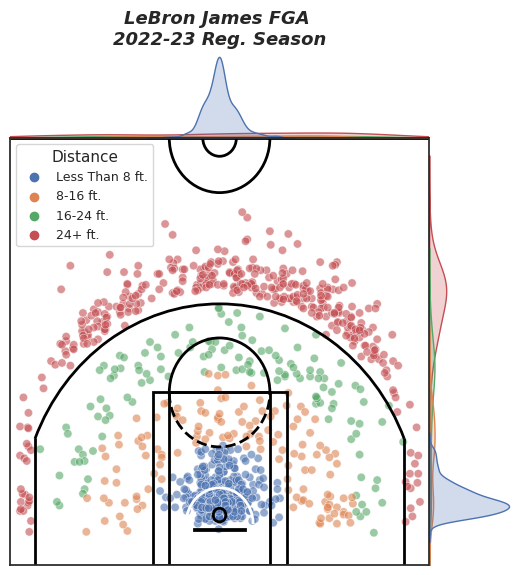

In [16]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(15,9.4))

#Plotting
sns.jointplot(data = lebron_23, 
              x='LOC_X', 
              y='LOC_Y', 
              kind='scatter', 
              hue='ZONE_RANGE', 
              hue_order=['Less Than 8 ft.', '8-16 ft.', '16-24 ft.', '24+ ft.'],
              space=0, 
              alpha=0.6)

#Court and axis
draw_court(outer_lines=True, color="black")
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.xlim(-250, 250)
plt.ylim(0, 470)

#Title
plt.title('LeBron James FGA \n2022-23 Reg. Season', 
          fontsize=13,
          loc='center',
          fontweight='bold',
          y=1.2, 
          fontstyle='oblique')

#Legend
plt.legend(title='Distance',
          loc='upper left',
          title_fontsize= 11,
          fontsize = 9)

plt.show()

<Figure size 1700x940 with 0 Axes>

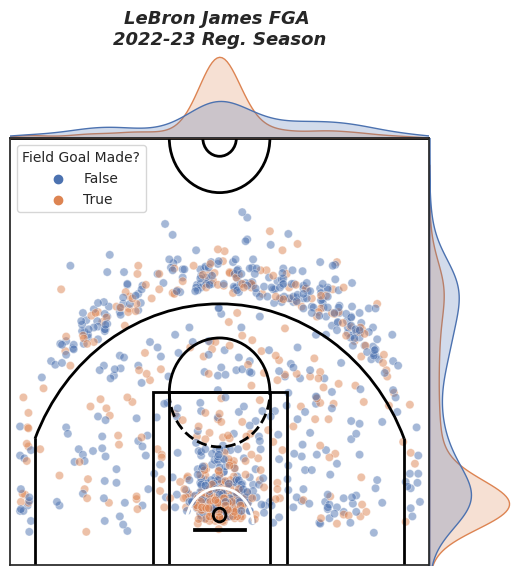

In [18]:
#setting up seaborn plot
sns.set_style("white")
plt.figure(figsize=(17,9.4))

#Plotting
ax = sns.jointplot(data = lebron_23, 
                   x='LOC_X', 
                   y='LOC_Y', 
                   kind='scatter',
                   hue='SHOT_MADE',
                   space=0, 
                   alpha=0.5)

#Court and axes
draw_court(outer_lines=True, color="black")
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.xlim(-250, 250)
plt.ylim(0, 470)

#Title
plt.title('LeBron James FGA \n2022-23 Reg. Season', 
          fontsize=13,
          loc='center',
          fontweight='bold',
          y=1.2, 
          fontstyle='oblique')

#Legend
plt.legend(title='Field Goal Made?', 
           loc='upper left', 
           title_fontsize= 10, 
           fontsize = 10)
           

plt.show()

We see a clear difference in Lebron's shooting habits with the graph on the right showing us a higher volume of 3-Pointers shot by Lebron in the 2022-23 season incomparison to the 2003-04 season.

**Classification model**

Now that we can see visually a difference in Lebrons shotting habits and a change in them from his rookie season to 2023

Lets build start the process of building a model that can show us how Lebron has changed when it comes to his efficeny when shooting from certain places on the court

In [17]:
#Getting DataFrame ready for preprocessing by removing remaining columns we don't need
lebron_ml = lebron_23.drop(['PLAYER_NAME', 'ZONE_RANGE', 'SEASON_2'], axis=1, inplace=False)

#Making 'Shot_Made' values into numerical values using label encoding 
le = LabelEncoder()
label = le.fit_transform(lebron_ml['SHOT_MADE'])
label
lebron_ml.loc[:, 'SHOT_MADE'] = label

#Reordering columns to have our dependent variable at the end
lebron_ml = lebron_ml[['LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'SHOT_MADE']]


lebron_ml.head()

,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,SHOT_MADE
116361,37.0,310.5,26,1,9,26,0
116363,-18.0,212.5,16,1,8,38,0
116364,70.0,143.5,11,1,8,10,0
116368,26.0,68.5,3,1,5,24,1
116378,-229.0,65.5,22,1,1,2,0


**Train Test split and Normalize Data**

In [22]:
#features
X = lebron_ml.iloc[:, :-1].values
y = lebron_ml.iloc[:, -1].values

#splitting training set into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

#Feature Scaling after we split our data into Train and Test
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_test)

#classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
#classifier.fit(X_train, y_train)

#y_pred = classifier.predict(X_test)
#y_pred = y_pred.reshape(len(y_pred),1)

#np.set_printoptions(precision=2)
#lebron23_predict = pd.DataFrame(np.concatenate((lebron_ml.values.reshape(len(y_pred),1), y_pred)))

[[-0.14000539 -1.13920448 -1.08210235  0.27416006 -0.60866516  0.14488157]
 [-0.07461365 -0.50074648 -0.7055006   1.13366508  0.53039152 -0.92740414]
 [-0.12910677 -0.75410283 -0.98795191  1.13366508 -0.03913682 -0.98384023]
 ...
 [-0.08551228 -0.70343156 -0.89380148 -0.58534495  0.81515569 -1.04027632]
 [-0.08551228 -0.8047741  -0.98795191 -1.44484997  1.09991986 -1.66107331]
 [-2.72297918 -0.31832991  1.08335769  0.27416006  0.53039152  1.668656  ]]


From our data we see the common trend of every one in the NBA attempting and making more 3-Point shots as every year passes. A change like this doesn't come to be without there being an incentive of course or external influence off the court. Starting around the *2013-14* and *2014-2015* seasons behind the scenes the NBA was also going through a but with analstic   with playoff clinching thewhile providing a recipe for success.

# **Acknowledgements**

Thank you to JP Hwang for his substack and medium articles which went extensively into nba data visualization

https://github.com/databyjp

Thank you you to ****Bradley Fay**** for providing a template for drawing NBA Courts within python

https://github.com/bradleyfay

****Dominic Samangy**** 

https://github.com/DomSamangy

In [ ]:

#col_names = ['LOC_X', 'LOC_Y']
#features = data[col_names]

#scaler = StandardScaler().fit(features.values)
#features = scaler.transform(features.values)
#scaled_features = pd.DataFrame(features, columns = col_names)

#Normalizing location data in dataset (LOC_X & LOC_Y)
#A = X_train[['LOC_X', 'LOC_Y']].copy()
#B = X_test[['LOC_X', 'LOC_Y']].copy()
